Згорткові мережі

In [49]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from os import path
import time

In [50]:
model_name = 'Lab4.h5'
model_weights = 'Lab4_weights.h5'
normalize_type = 'float32'
normalize_divider = 256
images_to_take_num = 3500
training_text = "Training -"
test_text = "Testing -"
validation_text = "Validation -"
batch_size = 128
loss_type = 'sparse_categorical_crossentropy'
# A type of activation function that transforms the 
# value results of a neuron. The transformation imposed
# by ReLU on values from a neuron is represented by
# the formula y=max(0,x). The ReLU activation function
# clamps down any negative values from the neuron to 0,
# and positive values remain unchanged. The result of this
# mathematical transformation is utilized as the output
# of the current layer and used as input to
# a consecutive layer within a neural network
relu_activation = 'relu'
padding_type = "same"
# A type of activation function that is utilized to
# derive the probability distribution of a set of numbers
# within an input vector. The output of a softmax
# activation function is a vector in which its set of
# values represents the probability of an occurrence of
# a class or event. The values within the vector all add up to 1
softmax_activation = 'softmax'
input_image_size = 128
learning_rate = 0.001
accuracy_metrics = 'accuracy'
epochs = 10
validation_freq = 1

In [51]:
airplane_image_type = 'Airplane'
automobile_image_type = 'Automobile'
bird_image_type = 'Bird'
cat_image_type = 'Cat'
deer_image_type = 'Deer'
dog_image_type = 'Dog'
frog_image_type = 'Frog'
horse_image_type = 'Horse'
ship_image_type = 'Ship'
truck_image_type = 'Truck'

In [52]:
image_types = [airplane_image_type, automobile_image_type, bird_image_type, cat_image_type, deer_image_type, dog_image_type, frog_image_type, horse_image_type, ship_image_type, truck_image_type]

In [53]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# Normalizes images: `uint8` -> `float32`
# TFDS provide images of type tf.uint8, while the model expects
# tf.float32. Therefore, you need to normalize images
x_train = x_train.astype(normalize_type) / normalize_divider
x_test = x_test.astype(normalize_type) / normalize_divider

In [54]:
x_validation, y_validation = x_train[:images_to_take_num], y_train[:images_to_take_num]
x_train, y_train = x_train[images_to_take_num:], y_train[images_to_take_num:]

In [55]:
print(y_train[0])
print(y_validation[0])

[6]
[6]


In [56]:
xy_train_origin = tf.data.Dataset.from_tensor_slices((x_train, y_train))
xy_test_origin = tf.data.Dataset.from_tensor_slices((x_test, y_test))
xy_validation_origin = tf.data.Dataset.from_tensor_slices((x_validation, y_validation))

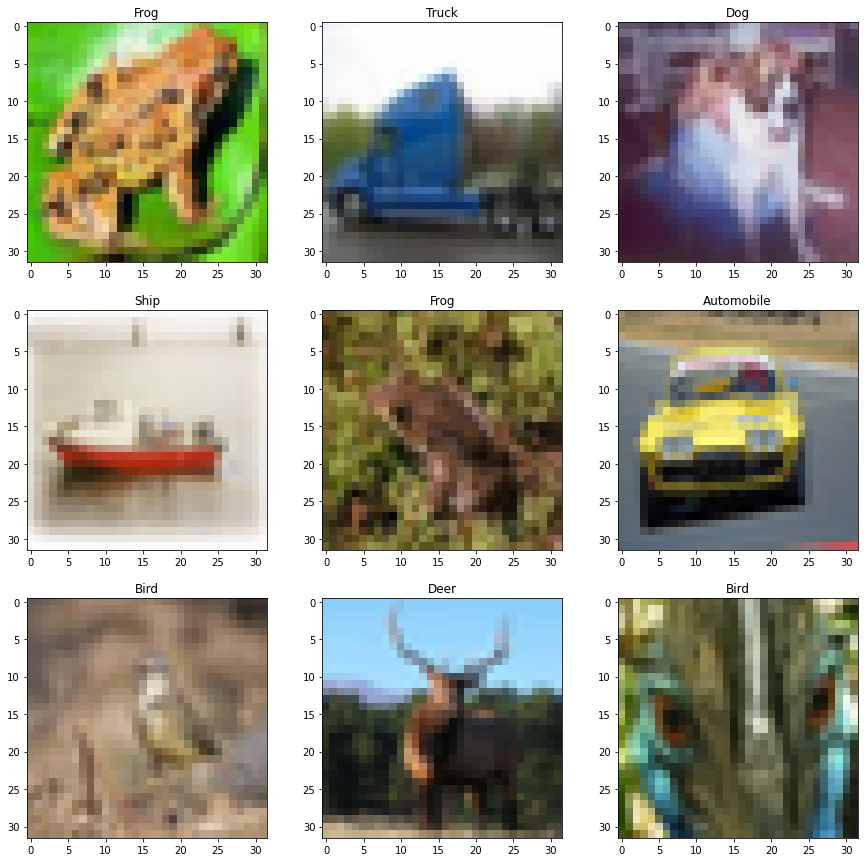

In [57]:
plt.figure(figsize=(15,15))
for i, (img, name) in enumerate(xy_train_origin.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(image_types[name.numpy()[0]])

In [58]:
def get_image_and_name(img, name):
    # Preparing the data (normzlization and scaling)
    img = tf.img.per_image_standardization(img)
    img = tf.image.resize(img, (input_image_size, input_image_size))

    return img, name

In [59]:
# Get the size of sets
xy_train_size = tf.data.experimental.cardinality(xy_train_origin).numpy()
print(training_text, xy_train_size)
xy_test_size = tf.data.experimental.cardinality(xy_test_origin).numpy()
print(test_text, xy_test_size)
xy_validation_size = tf.data.experimental.cardinality(xy_validation_origin).numpy()
print(validation_text, xy_validation_size)

Training - 46500
Testing - 10000
Validation - 3500


In [60]:
def preprocess_dataset(origin_dataset):
  new_dataset = (origin_dataset
                  .map(get_image_and_name)
                  .shuffle(buffer_size = xy_train_size)
                  .batch(batch_size = batch_size, drop_remainder = True))
  
  return new_dataset

In [61]:
xy_train = preprocess_dataset(xy_train_origin)
xy_test = preprocess_dataset(xy_test_origin)
xy_validation = preprocess_dataset(xy_validation_origin)

In [62]:
model = keras.models.Sequential([
    # A convolution is a mathematical term that describes a dot
    # product multiplication between two sets of elements.
    # Within deep learning the convolution operation acts 
    # on the filters/kernels and image data array within
    # the convolutional layer. Therefore a convolutional layer
    # is simply a layer the houses the convolution operation 
    # that occurs between the filters and the images 
    # passed through a convolutional neural network
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation = relu_activation, input_shape=(input_image_size, input_image_size,3)),
    # Batch Normalization is a technique that mitigates 
    # the effect of unstable gradients within a neural 
    # network through the introduction of an additional
    # layer that performs operations on the inputs from 
    # the previous layer. The operations standardize and
    # normalize the input values, after that the input
    # values are transformed through scaling and shifting operations
    keras.layers.BatchNormalization(),
    # Max pooling is a variant of sub-sampling where the maximum
    # pixel value of pixels that fall within the receptive 
    # field of a unit within a sub-sampling layer is
    # taken as the output. The max-pooling operation
    # below has a window of 2x2 and slides across the
    # input data, outputting an average of the
    # pixels within the receptive field of the kernel.
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation = relu_activation, padding = padding_type),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation = relu_activation, padding = padding_type),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Takes an input shape and flattens the input image data into a one-dimensional array
    keras.layers.Flatten(),
    # A dense layer has an embedded number of arbitrary 
    # units/neurons within. Each neuron is a perceptron
    keras.layers.Dense(4096, activation = relu_activation),
    # Dropout technique works by randomly reducing the
    # number of interconnecting neurons within
    # a neural network. At every training step, each
    # neuron has a chance of being left out, or
    # rather, dropped out of the collated
    # contributions from connected neurons
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation = relu_activation),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = softmax_activation)
])

In [63]:
model.compile(loss = loss_type, optimizer=tf.optimizers.Adam(learning_rate = learning_rate), metrics=[accuracy_metrics])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 96)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

In [64]:
if (path.exists(model_name)):
  model = tf.keras.models.load_model(model_name)
else:
  model.fit(xy_train,
          epochs = epochs,
          validation_data = xy_validation,
          validation_freq = validation_freq)
  model.save(model_name)
  model.save_weights(model_weights)

In [65]:
model.evaluate(xy_test)

78/78 [==============================] - 66s 826ms/step - loss: 0.7669 - accuracy: 0.7576


[0.7668707966804504, 0.7576121687889099]